Opening file and making a dataframe out of it

In [64]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats

# Step 1: Read the CSV file into a DataFrame
file_path = 'Stocks/evtc.us.txt'  # Replace with your actual file path
df = pd.read_csv(file_path)
numeric_columns = ["Open", "High", "Low", "Close", "Volume"]

# Step 2: Convert the 'Date' column to datetime format (assuming the file has a Date column)
df['Date'] = pd.to_datetime(df['Date'])

# Generate the full date range (weekends included)
full_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max())

# Create a new DataFrame with the full date range
full_df = pd.DataFrame(full_dates, columns=['Date'])

# Merge the original data with the full date range, filling missing dates with NaN
df = pd.merge(full_df, df, on='Date', how='left')

all_columns = numeric_columns.copy()
all_columns.append("Date")

df = df[all_columns]

Filling missing values

In [65]:
df["Volume"].fillna(0, inplace=True)
df["Open"].interpolate(inplace=True)
df["High"].interpolate(inplace=True)
df["Low"].interpolate(inplace=True)
df["Close"].interpolate(inplace=True)

C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\3032190843.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Volume"].fillna(0, inplace=True)
C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\3032190843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

Moving average

In [66]:
# df_average = df.copy(deep=True)
# df_average[numeric_columns] = df_average[numeric_columns].rolling(window=3).mean()
# df_average.bfill(inplace=True)
# print(df_average)

Find and remove outliers (new)

C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\94265111.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cleaned[o][i] = float('nan')
C:\Users\Tim\AppData\Local\Temp\ipykernel_29188\94265111.py:17: SettingWithCopyWarning: 
A value is

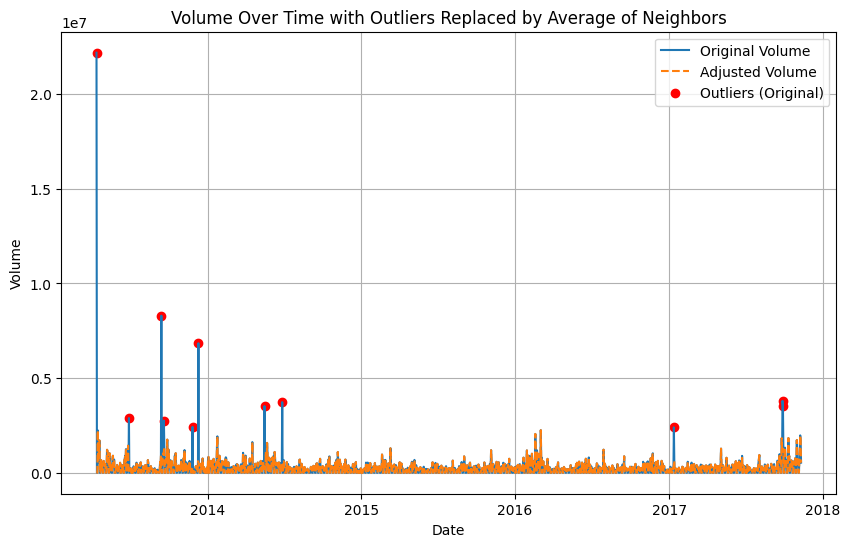

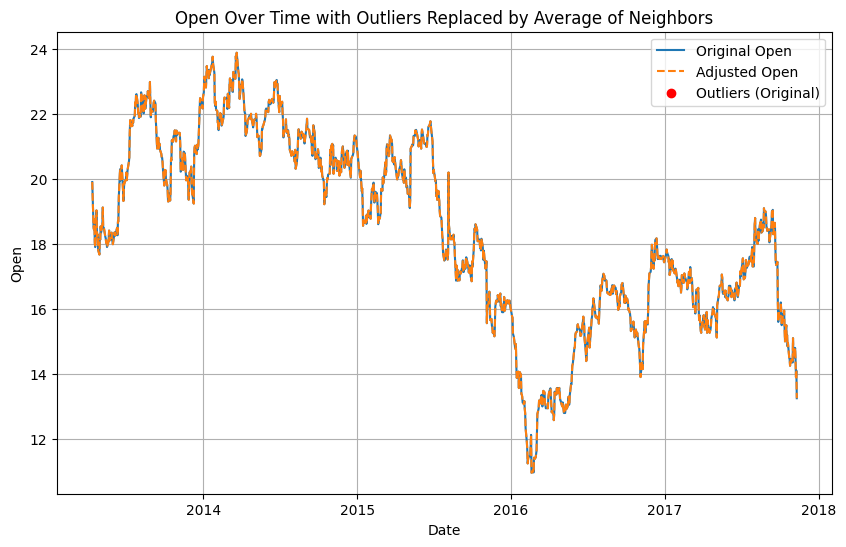

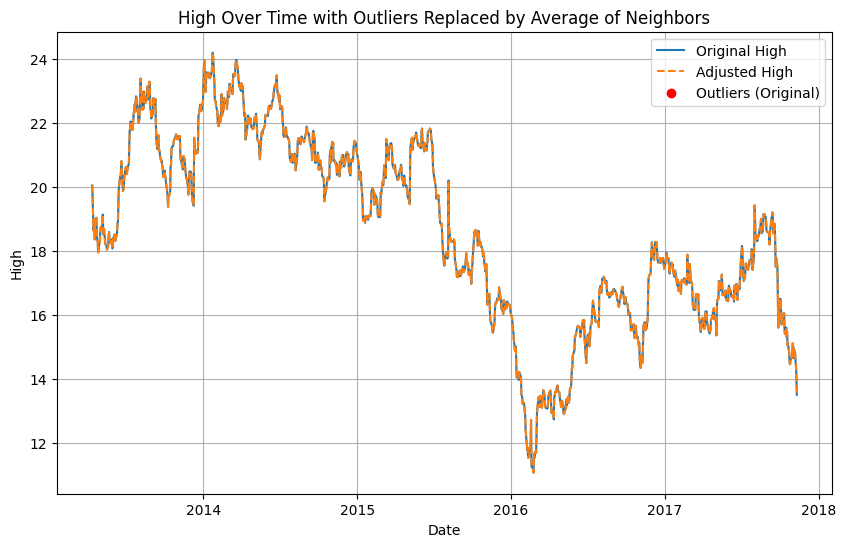

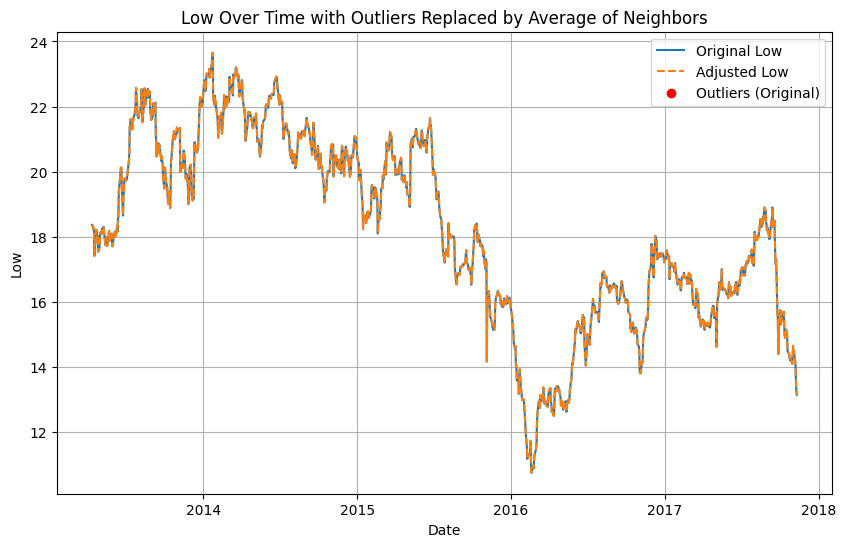

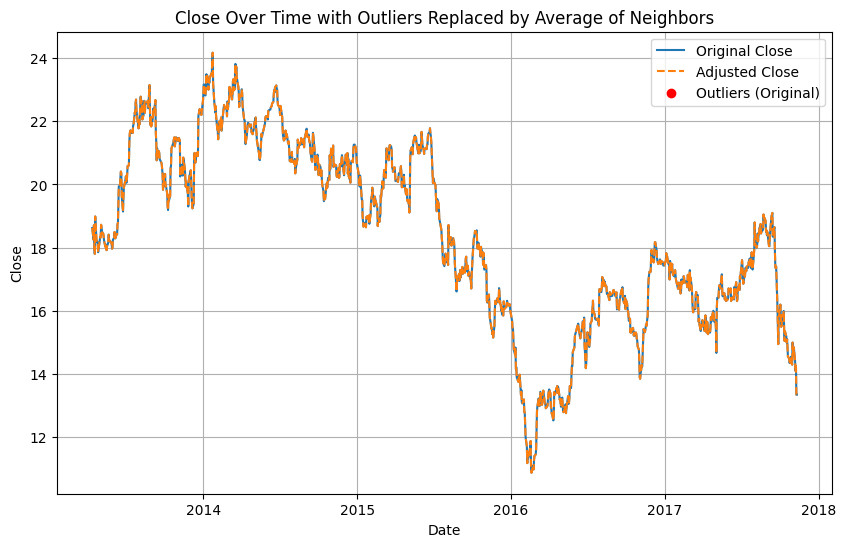

In [67]:
z_scores = {}

for column_name in numeric_columns:
    z_scores[column_name] = np.abs(stats.zscore(df[column_name]))

z_score_threshold = 3

outliers = {}
for column_name in z_scores.keys():
    outliers[column_name] = (z_scores[column_name] > z_score_threshold)

df_cleaned = df.copy(deep=True)

for o in outliers.keys():
    for i, x in enumerate(outliers[o]):
        if x:
            df_cleaned[o][i] = float('nan')

for column_name in numeric_columns:
    df_cleaned[column_name].interpolate(inplace=True)
    df_cleaned[column_name].bfill(inplace=True)

# TODO: Plot outliers over the other values


def plot_original_and_adjusted(df_before, df_after, column_name):
    """
    Function to plot the original and adjusted data, highlighting the outliers.
    
    Parameters:
    - df: The input dataframe containing the original and adjusted data.
    - column_name: The name of the column to plot.
    
    Returns:
    - A plot showing the original and adjusted column values over time, with outliers marked.
    """

    # Plot the original and adjusted column data
    plt.figure(figsize=(10, 6))
    plt.plot(df_before['Date'], df_before[column_name], label=f'Original {column_name}')
    plt.plot(df_after['Date'], df_after[column_name], label=f'Adjusted {column_name}', linestyle='--')

    # Highlight the outliers in the original data
    outliers = df_before[~df_before[column_name].isin(df_after[column_name])]
    plt.scatter(outliers['Date'], outliers[column_name], color='red', label='Outliers (Original)', marker='o')

    # Customize the plot
    plt.title(f'{column_name} Over Time with Outliers Replaced by Average of Neighbors')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

plot_original_and_adjusted(df, df_cleaned, "Volume")
plot_original_and_adjusted(df, df_cleaned, "Open")
plot_original_and_adjusted(df, df_cleaned, "High")
plot_original_and_adjusted(df, df_cleaned, "Low")
plot_original_and_adjusted(df, df_cleaned, "Close")


PCA (Open, High, Low, Close)

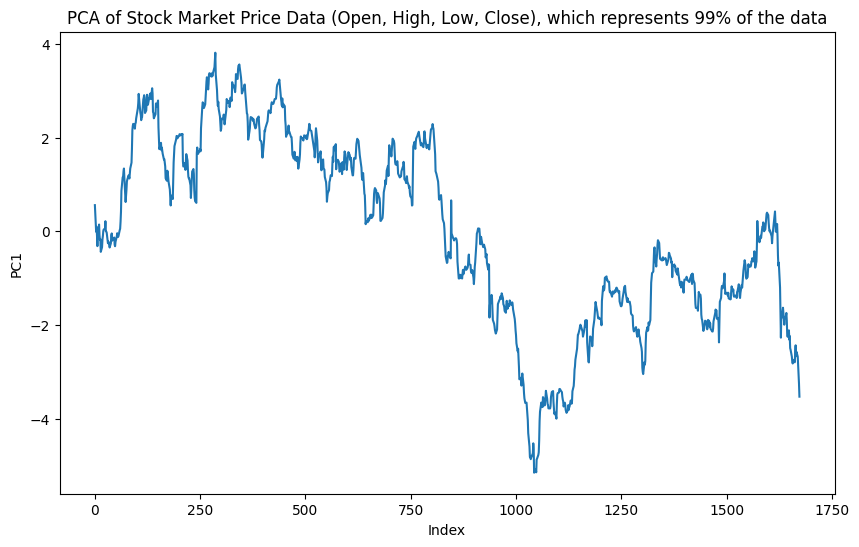

In [72]:
def scale_and_do_pca_on_open_high_low_close(dfc: pd.DataFrame):
    df = dfc.copy(deep=True)
    scaler = StandardScaler()
    wanted_columns = numeric_columns.copy()
    wanted_columns.remove("Volume")
    scaled = scaler.fit_transform(df[wanted_columns])
    pca = PCA(n_components=0.99)
    pca_res = pca.fit_transform(scaled)
    # print(train_pca)
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, len(pca_res)), pca_res)
    plt.xlabel('Index')
    plt.ylabel('PC1')
    plt.title('PCA of Stock Market Price Data (Open, High, Low, Close), which represents 99% of the data')
    plt.show()

scale_and_do_pca_on_open_high_low_close(df_cleaned)

Time series decomposition

In [46]:
# dfc.dropna(inplace=True)
# dfc_year = df_cleaned.head(365)
# print(dfc_year)

def do_seasonal_additive_decompose(column, period=7):
    return seasonal_decompose(column, model="additive", period=period)

# volume_result = do_seasonal_additive_decompose(dfc_year["Volume"])
# volume_result.plot()
# open_result = do_seasonal_additive_decompose(dfc_year["Open"])
# open_result.plot()
# high_result = do_seasonal_additive_decompose(dfc_year["High"])
# high_result.plot()
# low_result = do_seasonal_additive_decompose(dfc_year["Low"])
# low_result.plot()
# close_result = do_seasonal_additive_decompose(dfc_year["Close"])
# close_result.plot()

def decompose_column(column):
    result = do_seasonal_additive_decompose(column, period=7)
    return pd.DataFrame({
        'trend': result.trend,
        'seasonal': result.seasonal,
        'residual': result.resid
    })

decomposed = {}
for column_name in numeric_columns:
    decomposed[column_name] = decompose_column(df_cleaned[column_name])
    decomposed[column_name].dropna(inplace=True)


Scale the data

In [47]:
# def get_scaled_data_with_date_as_days_since_unix_epoch(df):
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df[numeric_columns])
#     df_new = pd.DataFrame(scaled_data, columns=numeric_columns)
#     unix_epoch = pd.Timestamp('1970-01-01')
#     df_new['Days_since_unix_epoch'] = (df['Date'] - unix_epoch).dt.days
#     return df_new

# df_scaled = get_scaled_data_with_date_as_days_since_unix_epoch(df_cleaned)
# print(df_scaled)

def scale_decomposed_data(decomposition):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(decomposition)
    return pd.DataFrame(scaled_data, columns = ['trend', 'seasonal', 'residuals'])

scaled_decomposition = {}
for column_name in numeric_columns:
    scaled_decomposition[column_name] = scale_decomposed_data(decomposed[column_name])
print(scaled_decomposition)

{'Open':          trend  seasonal  residuals
0     0.153565  0.756268  -1.941278
1     0.054258 -0.188228  -0.814108
2    -0.003816 -0.857308   1.974849
3    -0.020657  1.855297  -1.967396
4     0.003736 -1.338265  -3.059632
...        ...       ...        ...
1663 -1.306693 -1.338265  -0.943666
1664 -1.301735 -0.564485  -0.474318
1665 -1.361230  0.334336   1.048823
1666 -1.388498  0.756268   2.054915
1667 -1.450472 -0.188228   1.101886

[1668 rows x 3 columns], 'High':          trend  seasonal  residuals
0     0.150102 -0.370069  -2.600448
1     0.098084 -1.178010  -0.560469
2     0.069990  0.113545   0.917079
3     0.065820  2.285776  -2.981197
4     0.085573 -0.308807   0.621787
...        ...       ...        ...
1663 -1.286895 -0.308807   0.278890
1664 -1.313987 -0.286721   0.446936
1665 -1.348469 -0.249208   0.741103
1666 -1.374330 -0.370069   0.898967
1667 -1.445756 -1.178010   0.706721

[1668 rows x 3 columns], 'Low':          trend  seasonal  residuals
0    -0.049384 -0.465235

Train split

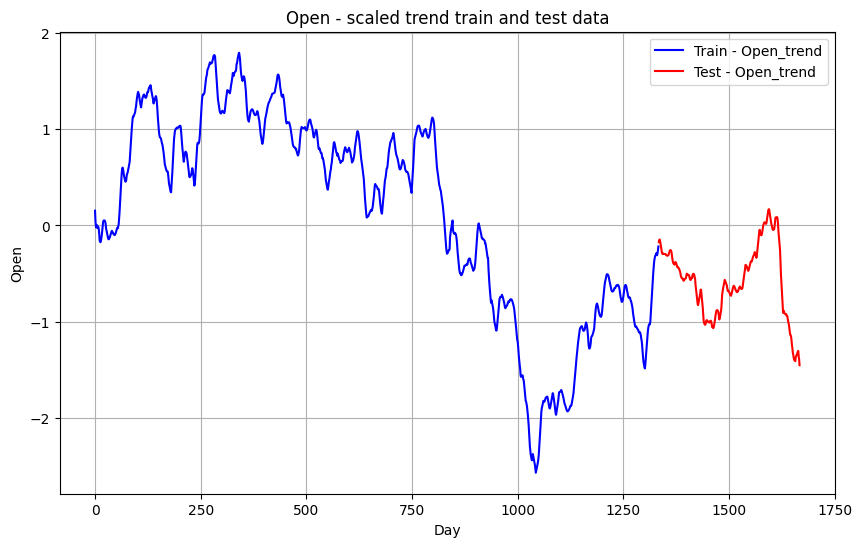

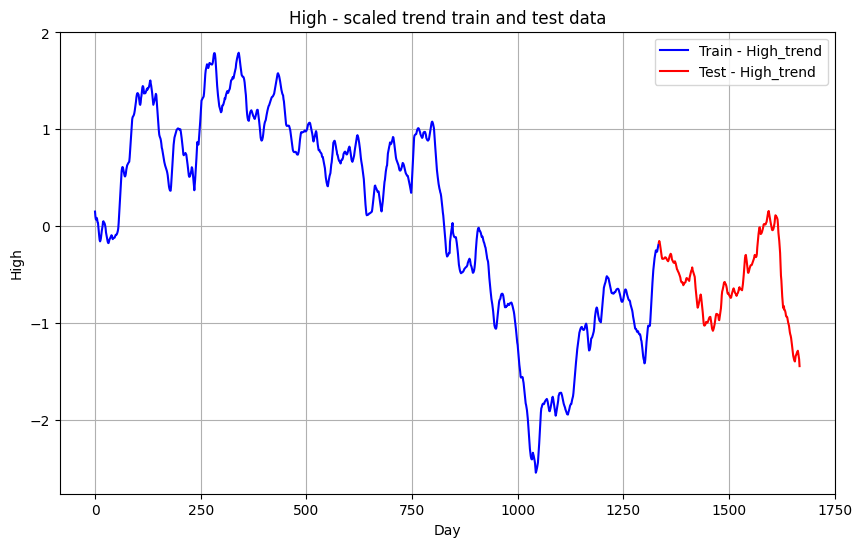

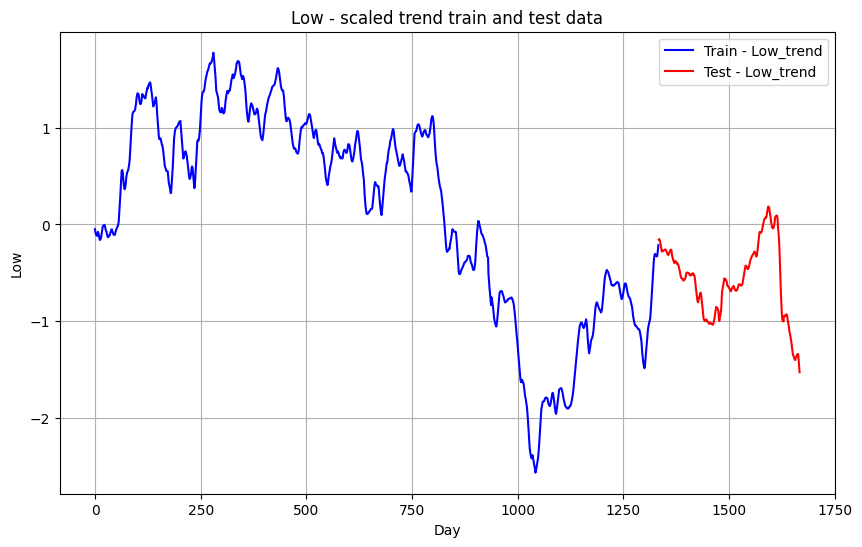

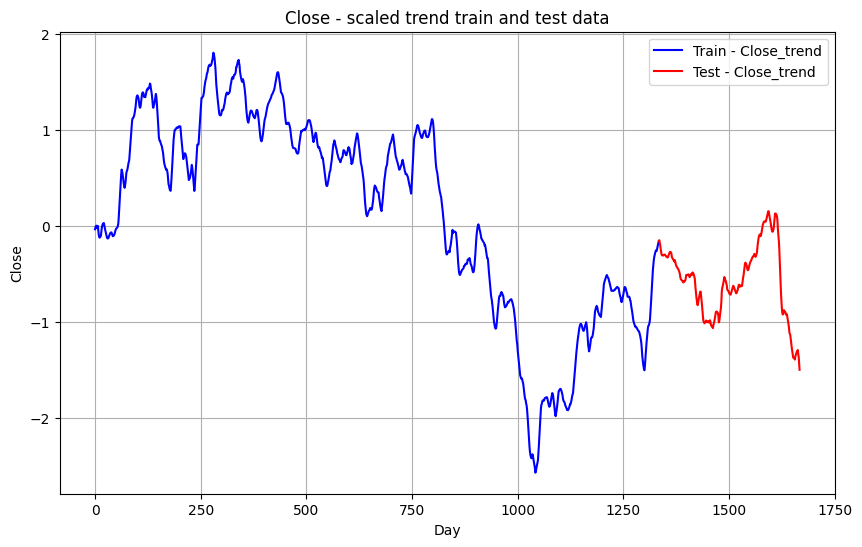

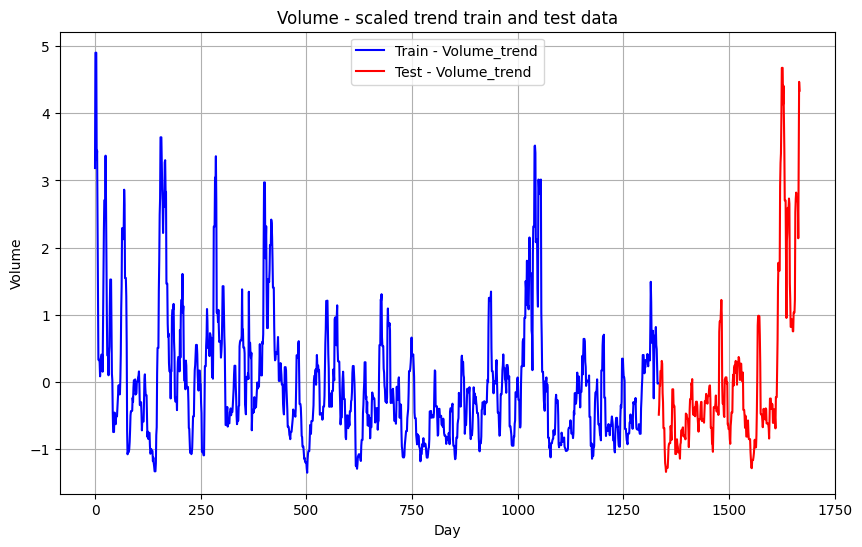

In [56]:
def get_train_and_test_data(scaled_decomposition):
    train_scaled, test_scaled = train_test_split(scaled_decomposition, test_size=0.2, shuffle=False)
    return [train_scaled, test_scaled]

def plot_train_and_test(train, test, column_name):
    # Plot the original and adjusted column data
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, len(train['trend'])), train['trend'], label=f'Train - {column_name}_trend', color="blue")
    plt.plot(range(len(train['trend']), len(train['trend']) + len(test['trend'])), test['trend'], label=f'Test - {column_name}_trend', color="red")
    # plt.plot(range(0, len(train['seasonal'])), train['seasonal'], label=f'Train - {column_name}_seasonality', color="blue")
    # plt.plot(range(0, len(test['seasonal'])), test['seasonal'], label=f'Test - {column_name}_seasonality', color="red")
    # plt.plot(range(0, len(train['residuals'])), train['residuals'], label=f'Train - {column_name}_residuals', color="blue")
    # plt.plot(range(0, len(test['residuals'])), test['residuals'], label=f'Test - {column_name}_residuals', color="red")
    # Customize the plot
    plt.title(f'{column_name} - scaled trend train and test data')
    plt.xlabel('Day')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

train_and_test_data = {}
for column_name in numeric_columns:
    train_and_test_data[column_name] = get_train_and_test_data(scaled_decomposition[column_name])
    plot_train_and_test(train_and_test_data[column_name][0], train_and_test_data[column_name][1], column_name)

PCA (On the time series decomposition)

          PC1       PC2       PC3
0    0.029376 -1.738649  0.141495
1   -0.033575 -0.991715  0.422349
2   -0.076045 -0.207891  0.868990
3   -0.007942 -0.065246  1.402632
4   -0.190326 -0.457333  0.309546
..        ...       ...       ...
329 -1.605602 -0.839394 -1.221375
330 -1.498547 -0.464040 -0.404859
331 -1.173354 -0.576091  1.330960
332 -0.941589 -0.788202  2.376084
333 -1.228565 -1.047984  1.089875

[334 rows x 3 columns]


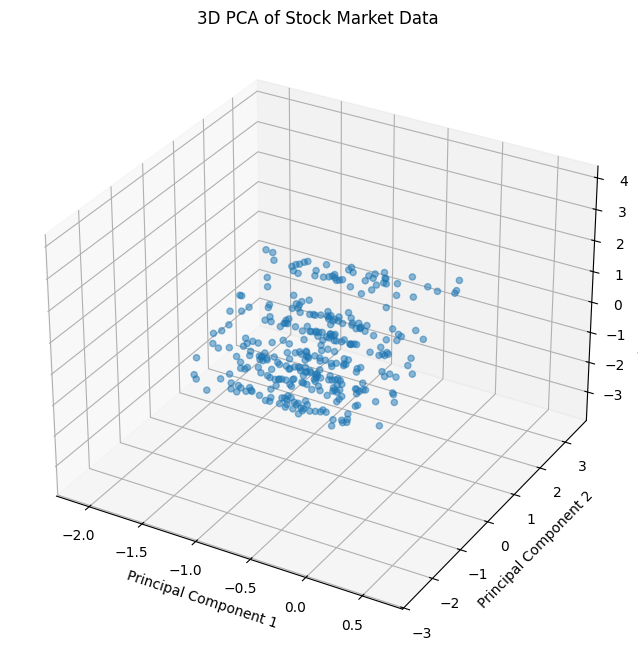

In [59]:
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_and_test_data["Open"][0])
test_pca = pca.transform(train_and_test_data["Open"][1])
# print(train_pca)
# print(test_pca)
test_p_df = pd.DataFrame(data=test_pca, columns=["PC1", "PC2", "PC3"])

print(test_p_df)

# Example 1D data
# Create the figure and axis
# plt.figure(figsize=(8, 2))  # Make the plot wider and less tall for a horizontal feel
# # Plot the horizontal line (constant value for y)
# plt.plot(test_p_df, np.zeros(len(test_p_df)), linestyle='-', color='green', linewidth=2)
# # Add square markers on the line
# plt.scatter(test_p_df, np.zeros(len(test_p_df)), color='green', edgecolor='black', marker='s', s=200)
# # Customize the plot
# plt.yticks([])  # Remove the y-axis
# plt.ylim(-0.5, 0.5)  # Keep a small y-range to maintain the horizontal line
# plt.title('Custom Horizontal Line with Square Markers')
# # Show the plot
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.scatter(test_p_df['PC1'], test_p_df['PC2'], alpha=0.5)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA of Stock Market Data (Open, High, Low, Close, Volume)')
# plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_p_df['PC1'], test_p_df['PC2'], test_p_df['PC3'], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Stock Market Data')
plt.show()